# Steady state weights compared to the theoretical predictions - Symmetrical

How do the network weights compare to the theory after the activity converges to a steady state?
* Gaussian bump activity
* Symmetrical Hebbian kernel

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.rc('figure', figsize=(12.0, 8.0))

In [26]:
def wrap_half_period(x: torch.Tensor, period: int):
	return (x + period//2) % period - period//2

def circ_norm_unnormalised(x: torch.Tensor, mean: torch.Tensor, stdev: float, wrap: int):
	return torch.exp(-wrap_half_period(x - mean, wrap)**2 / 2/stdev**2)

def get_rotating_gaussian(time: int, neurons: int, bump_speed: int, stdev: float):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(neurons))
	return circ_norm_unnormalised(x, (t*bump_speed) % neurons, stdev, neurons)

def convert_to_spikes(x: torch.Tensor, noise_ratio: float=0.0):
	return torch.rand_like(x) < (noise_ratio*torch.rand_like(x) + (1.0-noise_ratio)*(x / x.max()))

def sum_by_index(data: torch.Tensor, indices: torch.Tensor):
	return torch.zeros(indices.max().numpy()+1).index_add(0,indices.flatten(),data.flatten().float())

def roll_tensor_rows(tensor, roll_amounts):
	tensor_rolled = tensor[:, [*range(tensor.shape[1]),*range(tensor.shape[1]-1)]].clone()
	stride_0, stride_1 = tensor_rolled.stride()
	num_cols = tensor.shape[1]
	result = torch.as_strided(tensor_rolled, (*tensor.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[torch.arange(tensor.shape[0]), ((num_cols-roll_amounts) % num_cols).long()]

def get_time_periodic_profile(data: torch.Tensor, bump_speed: int):
	'''
	Return the average periodic spiking profile for the network (shifted so the centre angle is in the middle)

	:param data: Spiking output of the network [time*neurons]
	:param bump_speed: How many neurons the neural activity moves per timestep
	'''
	neurons = data.shape[1]
	shifts = (-torch.arange(neurons) // bump_speed).int()
	period = int(neurons // bump_speed)
	return torch.roll(torch.mean(torch.vstack(torch.split(roll_tensor_rows(data.T.float(), shifts), period, dim=1)), dim=0), period//2)

def get_weight_periodic_profile(weights: torch.Tensor):
	'''
	Return the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.mean(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0), neurons//2)

def get_weight_periodic_profile_stdev(weights: torch.Tensor):
	'''
	Return the standard deviation of the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.sqrt(torch.var(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0)), neurons//2)

def plot_with_stdev(t, x, stdev, **kwargs):
	plt.plot(t, x, **kwargs)
	plt.fill_between(t, x-stdev, x+stdev, alpha=0.2)

Create the input for the network

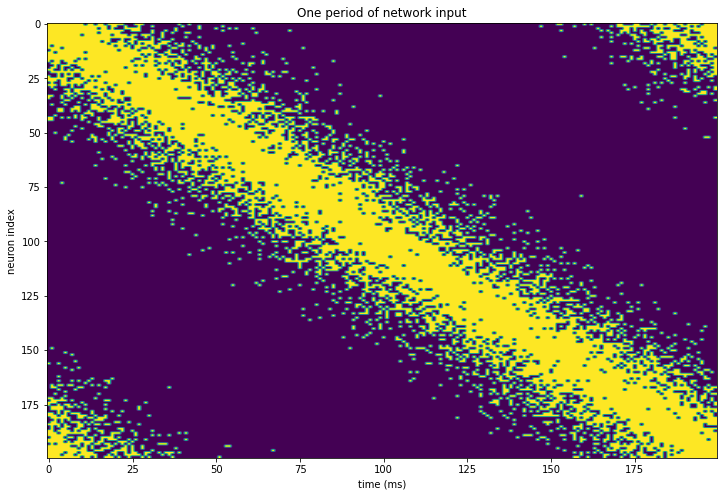

In [45]:
time = 15000 # 15 seconds seems to be enough time for it to settle
num_neurons = 200
bump_speed = 1
period = int(num_neurons // bump_speed)
input_noise_ratio = 0.
input_weight = 20 # mV / spike
input_sigma = num_neurons//10
dt = 1e-3 # time resolution is 1 ms

input_voltage = get_rotating_gaussian(time, num_neurons, bump_speed, input_sigma)
input_spikes = input_weight * convert_to_spikes(input_voltage, input_noise_ratio)

plt.imshow(input_spikes.T[:,:period])
plt.axis('auto')
plt.title('One period of network input')
plt.ylabel('neuron index')
plt.xlabel('time (ms)')
plt.show()

Set the STDP kernel and homeostatic rate for the network

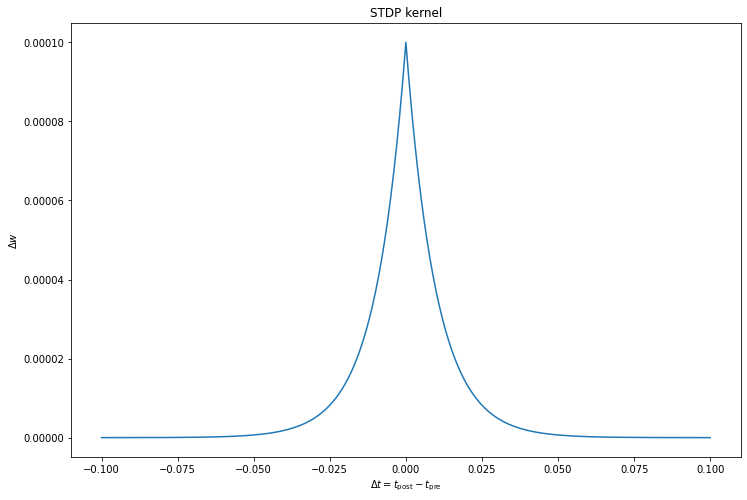

In [28]:
A_plus = 1e-4
A_minus = 1e-4
tau_stdp = 10e-3
gamma = 1e-5

kernel = lambda delta_t: \
	A_plus * torch.exp(-abs(delta_t) / tau_stdp) * (delta_t > 0) + \
	A_minus * torch.exp(-abs(delta_t) / tau_stdp) * (delta_t < 0) + \
	(A_plus+A_minus)/2 * (delta_t == 0)

delta_t = torch.arange(-period//2,period//2+1) * dt

plt.plot(delta_t, kernel(delta_t))
plt.xlabel(r'$\Delta t = t_{\rm{post}} - t_{\rm{pre}}$')
plt.ylabel(r'$\Delta w$')
plt.title('STDP kernel')
plt.show()

Get $\kappa_S$ and $\kappa_A$ for the network by integrating the kernel

In [29]:
t, A_plus_sym, A_minus_sym = sym.symbols('t A_+ A_-', real=True)
tau_stdp_sym = sym.Symbol(r'\tau', positive=True)
kernel_sym = sym.Piecewise(
	(A_plus_sym * sym.exp(-t / tau_stdp_sym), t >= 0), 
	(A_minus_sym * sym.exp(t / tau_stdp_sym), t < 0)
)

kappa_S = sym.integrate(kernel_sym, (t, -sym.oo, sym.oo))
print('kappa_S = ')
display(kappa_S)

kappa_A = sym.integrate(t*kernel_sym, (t, -sym.oo, sym.oo))
print('kappa_A = ')
display(kappa_A)

kappa_S = 


A_+*\tau + A_-*\tau

kappa_A = 


A_+*\tau**2 - A_-*\tau**2

Create the network of LIF neurons with homeostatic+STDP plasticity.

In [30]:
network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, tc_trace=tau_stdp*1e3, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

initial_weights = 0.1 * (torch.rand((lif_layer.n,lif_layer.n)))
initial_weights_copy = initial_weights.clone()
recurrent_connection = Connection(
    source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=[-A_minus, A_plus],
	gamma = gamma,
    w=initial_weights,
)
network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')

# Create and add monitors for spikes and voltages
monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r', 'x'), time=time)
network.add_monitor(monitor=monitor, name='LIF_monitor')

# Simulate network on input data
network.run(inputs={'LIF': input_weight*input_spikes}, time=time, progress_bar=True)

# Retrieve data from monitors for analysis
spikes = monitor.get('s')
voltages = monitor.get('v')
stdp_traces = monitor.get('x')
rates = monitor.get('r')

Plot the network spiking for the last two periods - check that it looks like a Gaussian bump as it should

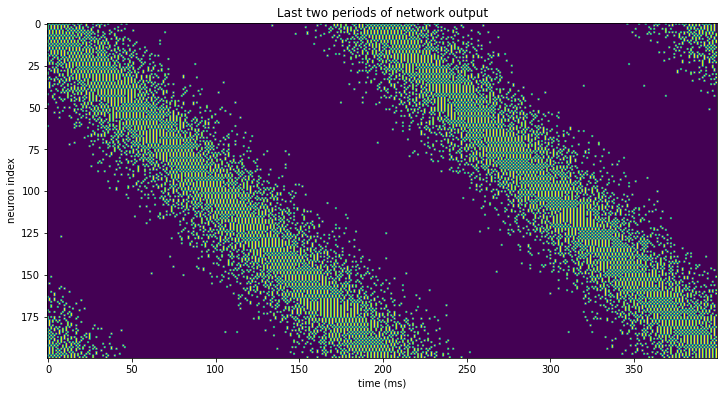

In [31]:
plt.imshow(spikes.squeeze().T[:,-2*period:])
plt.title('Last two periods of network output')
plt.xlabel('time (ms)')
plt.ylabel('neuron index')
plt.show()

Plot the activity profile averaged across all neurons (and centred with respect to each neuron) - looks like a Gaussian bump

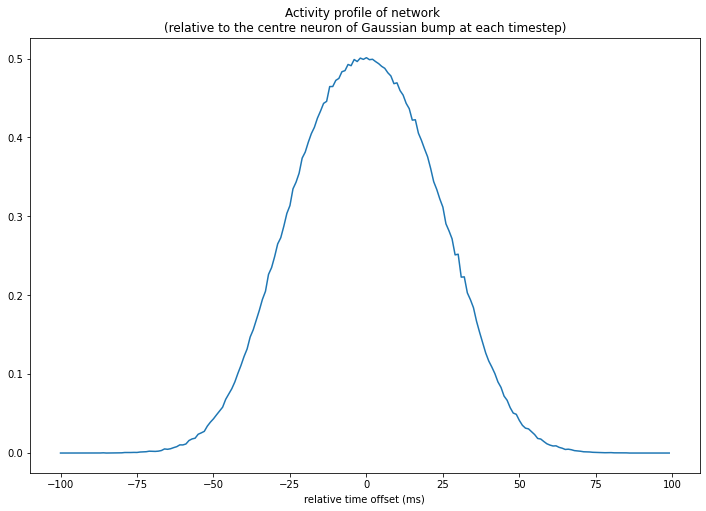

In [52]:
plt.plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes.squeeze()[:,-time//2:], bump_speed))
plt.title('Activity profile of network \n(relative to the centre neuron of Gaussian bump at each timestep)')
plt.xlabel('relative time offset (ms)')
plt.show()

Check that the weight matrix looks like we expect - it does

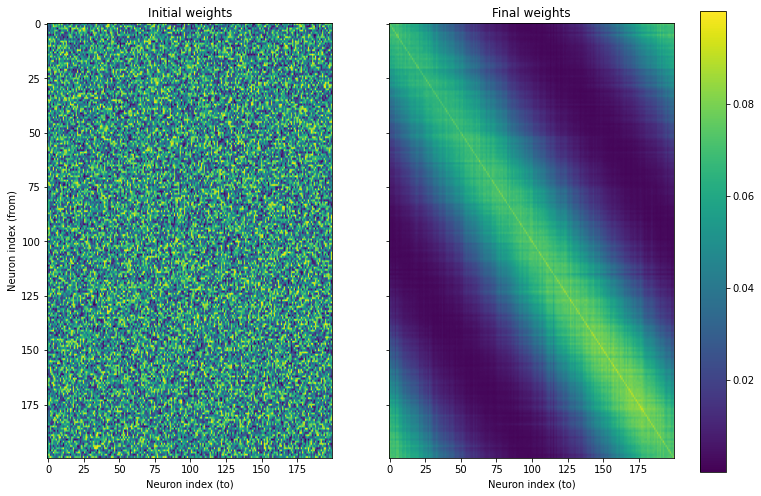

In [33]:
fig, axs = plt.subplots(1,2, sharey=True)
min_weight = min(initial_weights_copy.min().item(), recurrent_connection.w.min().item())
max_weight = max(initial_weights_copy.max().item(), recurrent_connection.w.max().item())

img1 = axs[0].imshow(initial_weights_copy, vmin=min_weight, vmax=max_weight, aspect='auto')
img2 = axs[1].imshow(recurrent_connection.w, vmin=min_weight, vmax=max_weight, aspect='auto')
axs[0].set_title('Initial weights')
axs[1].set_title('Final weights')
axs[0].set_ylabel('Neuron index (from)')
axs[0].set_xlabel('Neuron index (to)')
axs[1].set_xlabel('Neuron index (to)')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])
fig.colorbar(img2, cax=cbar_ax)
plt.show()

The weight profile after learning (centred relative to each neuron and averaged) show a Gaussian shape to self-reinforce an activity packet. The weight profile is somewhat broader than expected though.

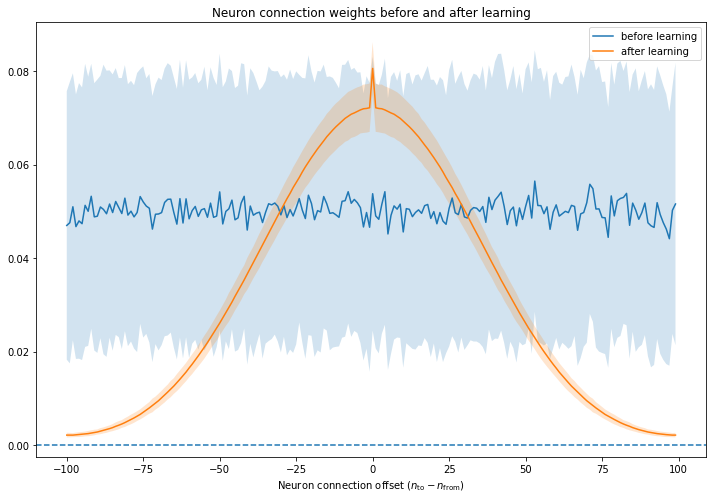

In [34]:
plot_weight_matrix = lambda weights, label: plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(weights), get_weight_periodic_profile_stdev(weights), label=label)
plot_weight_matrix(initial_weights_copy, 'before learning')
plot_weight_matrix(recurrent_connection.w, 'after learning')
plt.axhline(0, linestyle='--')
plt.legend()
plt.title('Neuron connection weights before and after learning')
plt.xlabel(r'Neuron connection offset ($n_{\rm{to}} - n_{\rm{from}}$)')
plt.show()

Examining the neuron firing rate traces - the neurons converge to a steady firing rate after ~5s.

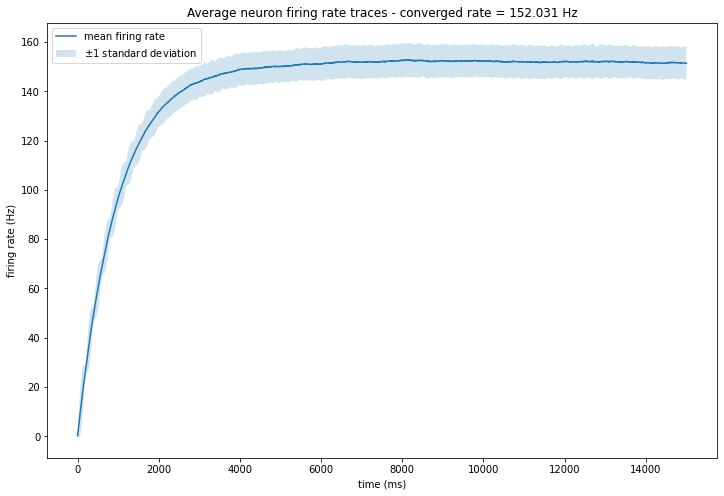

In [35]:
avg = rates.squeeze().mean(dim=1)
stdev = torch.sqrt(rates.squeeze().var(dim=1))
converged_firing_rate = rates[-time//2:].mean()
plot_with_stdev(torch.arange(time), avg, stdev)
plt.legend(['mean firing rate','$\\pm1$ standard deviation'])
plt.title(f'Average neuron firing rate traces - converged rate = {converged_firing_rate:.3f} Hz')
plt.xlabel('time (ms)')
plt.ylabel('firing rate (Hz)')
plt.show()

Now we want to examine the trajectory of a weight value over one period. First we simulate it over one more period

In [36]:
old_weights = recurrent_connection.w.clone()

# reset the monitor
monitor.time = period
monitor.reset_state_variables()

# Simulate network for one more period, then get the outputs
network.run(inputs={'LIF': input_weight*input_spikes[:,:period]}, time=period)

last_period_spikes = monitor.get('s').squeeze().T
last_period_traces = monitor.get('x').squeeze().T
last_period_rates = monitor.get('r').squeeze().T

new_weights = recurrent_connection.w.clone()

Now we check how the weight would have evolved for a single neuron (pre,post) pair over the period

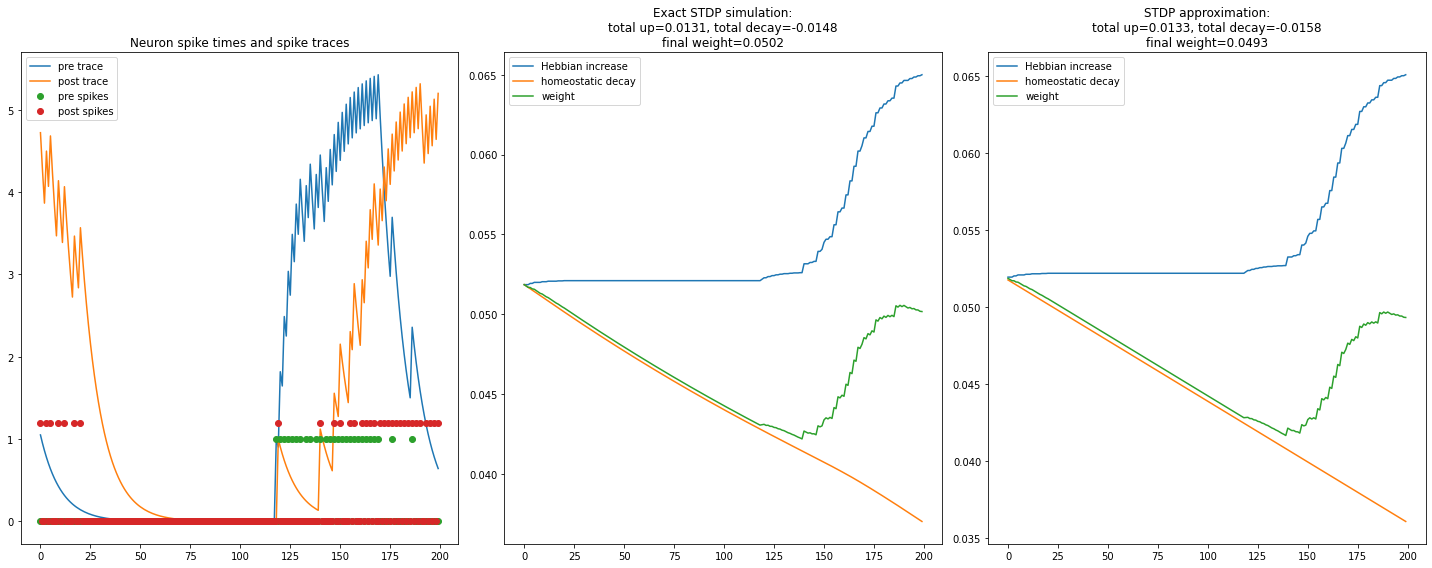

If weight is constant, weight ~= up/decay = 0.0133/0.3041 = 0.0436


In [42]:
pre = 150
post = 180

# simulate spike based learning rule
weights = torch.zeros(period)
weight_up = torch.zeros(period)
weight_decay = torch.zeros(period)
weights[0] = old_weights[pre,post]
for i in range(1,period):
	weight_up[i] = A_plus * last_period_traces[pre,i] * last_period_spikes[post,i] + A_minus * last_period_traces[post,i] * last_period_spikes[pre,i]
	weight_decay[i] = -gamma*last_period_rates[post,i] * weights[i-1]
	weights[i] = weights[i-1] + weight_up[i] + weight_decay[i]

# approximate spike based learning rule assuming weight and firing rate is constant
approx_up = torch.cumsum(A_plus * last_period_traces[pre,:] * last_period_spikes[post,:] + A_minus * last_period_traces[post,:] * last_period_spikes[pre,:], 0)
approx_decay = torch.cumsum(-torch.ones(period) * old_weights[pre,post] * converged_firing_rate * gamma, 0)
approx_weights = old_weights[pre,post] + approx_up + approx_decay

# plot
fig, axs = plt.subplots(1,3, figsize=(20,8))

axs[0].plot(last_period_traces[pre,:], label='pre trace')
axs[0].plot(last_period_traces[post,:], label='post trace')
axs[0].plot(last_period_spikes[pre,:], 'o', label='pre spikes')
axs[0].plot(last_period_spikes[post,:] * 1.2, 'o', label='post spikes')
axs[0].set_title('Neuron spike times and spike traces')
axs[0].legend()

axs[1].plot(old_weights[pre,post] + torch.cumsum(weight_up,0), label='Hebbian increase')
axs[1].plot(old_weights[pre,post] + torch.cumsum(weight_decay,0), label='homeostatic decay')
axs[1].plot(weights, label='weight')
axs[1].set_title(f'Exact STDP simulation:\ntotal up={weight_up.sum():.4f}, total decay={weight_decay.sum():.4f}\nfinal weight={weights[-1]:.4f}')
axs[1].legend()
			

axs[2].plot(old_weights[pre,post] + approx_up, label='Hebbian increase')
axs[2].plot(old_weights[pre,post] + approx_decay, label='homeostatic decay')
axs[2].plot(approx_weights, label='weight')
axs[2].set_title(f'STDP approximation:\ntotal up={approx_up[-1]:.4f}, total decay={approx_decay[-1]:.4f}\nfinal weight={approx_weights[-1]:.4f}')
axs[2].legend()
plt.tight_layout()
plt.show()

print(f'If weight is constant, weight ~= up/decay = {approx_up[-1]:.4f}/{converged_firing_rate*gamma*period:.4f} = {(approx_up[-1])/(converged_firing_rate*gamma*period):.4f}')

Approximating the STDP weight updates by assuming the weight is constant for homeostatic updates (getting constant decay instead of exponential) doesn't seem to have a significant negative effect.

Doing the same for every neuron pair over the period gives a weight matrix and weight profile very closely matching the actual - assuming a constant weight and firing rate seems reasonable

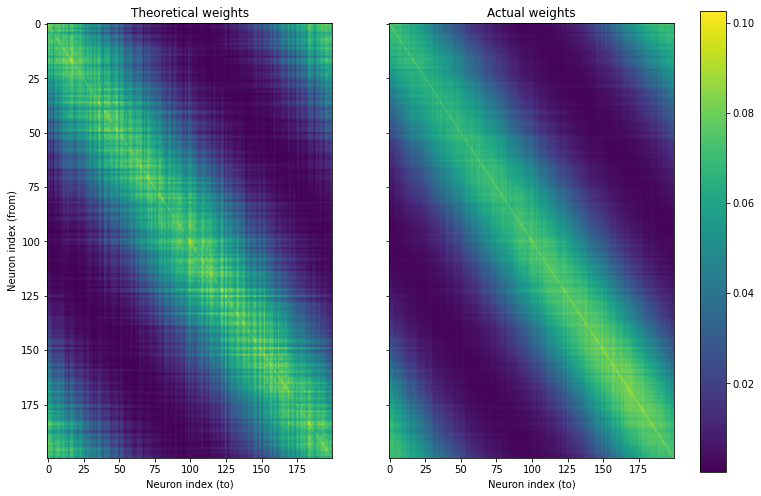

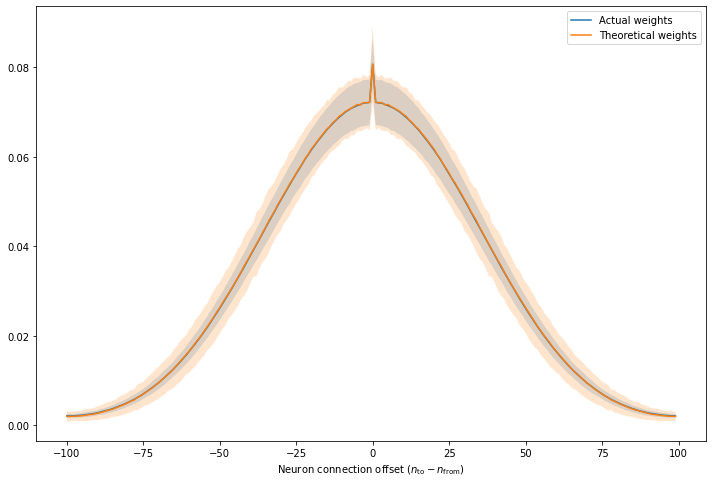

In [38]:
w = torch.zeros(num_neurons,num_neurons)
for pre in range(num_neurons):
	for post in range(num_neurons):
		up = A_plus * torch.sum(last_period_traces[pre,:] * last_period_spikes[post,:]) + A_minus * torch.sum(last_period_traces[post,:] * last_period_spikes[pre,:])
		decay = gamma * converged_firing_rate * period
		w[pre,post] = up / decay

fig, axs = plt.subplots(1,2, sharey=True)
min_weight = min(w.min().item(), new_weights.min().item())
max_weight = max(w.max().item(), new_weights.max().item())

img1 = axs[0].imshow(w, vmin=min_weight, vmax=max_weight, aspect='auto')
img2 = axs[1].imshow(new_weights, vmin=min_weight, vmax=max_weight, aspect='auto')
axs[0].set_title('Theoretical weights')
axs[1].set_title('Actual weights')
axs[0].set_ylabel('Neuron index (from)')
axs[0].set_xlabel('Neuron index (to)')
axs[1].set_xlabel('Neuron index (to)')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])
fig.colorbar(img2, cax=cbar_ax)
plt.show()

plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(new_weights), get_weight_periodic_profile_stdev(new_weights), label='Actual weights')
plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(w), get_weight_periodic_profile_stdev(w), label='Theoretical weights')
plt.legend()
plt.xlabel(r'Neuron connection offset ($n_{\rm{to}} - n_{\rm{from}}$)')
plt.show()

If we don't use the actual spike times but instead just the desired firing rates (from the inputs), how closely do the actual weights match those we calculate?
* `input_voltage` is the probability of an input spike in each time step (`dt`), so the firing rate is `input_voltage/dt`
  * this is divided by 2 because the refractory period of 1 ms means the neurons can fire at most on each alternating timestep (500 Hz)
* compare the exact method (convolve STDP kernel, pre-synaptic firing rate and post-synaptic firing rate) to the Taylor series approximation ($\beta_S x_{\text{pre}} \ast x_{\text{post}} + \beta_A x_{\text{pre}} \ast \dot{x}_{\text{post}}$)
  * both make predictions quite similar to the actual weight values

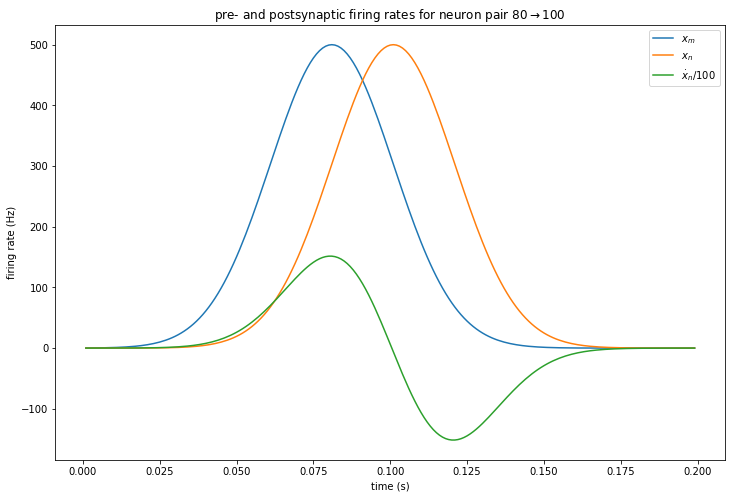

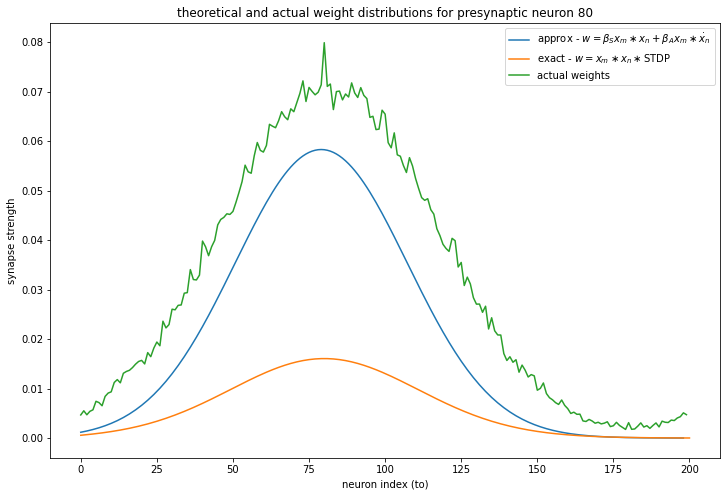

In [57]:
K_S = (A_plus + A_minus)*tau_stdp
K_A = (A_plus - A_minus)*tau_stdp**2

beta_S = K_S / (gamma * period * converged_firing_rate)
beta_A = K_A / (gamma * period * converged_firing_rate)

pre = 80
post = 100

t = torch.arange(1,period) * dt
kernel_t = torch.linspace(-period//2,period//2,period+1) * dt
x_pre = input_voltage[pre,:period] / dt / 2
x_post = input_voltage[post,:period] / dt / 2
x_post_dot = np.diff(x_post) / dt
# chop off 1 so it's the same length as the derivative
x_pre = x_pre[:len(x_post_dot)]
x_post = x_post[:len(x_post_dot)]

plt.plot(t, x_pre, label=r'$x_m$')
plt.plot(t, x_post, label=r'$x_n$')
plt.plot(t, x_post_dot / 1e2, label=r'$\dot{x}_n / 100$')
plt.legend()
plt.title(f'pre- and postsynaptic firing rates for neuron pair ${pre}\\rightarrow{post}$')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.show()

# need to do 1/dt * conv(x1*dt, x2*dt) to emulate continuous time convolution
plt.plot((beta_S*np.correlate(x_pre*dt,x_post*dt,'same') + beta_A*np.correlate(x_pre*dt,x_post_dot*dt,'same'))/dt, label=r'approx - $w = \beta_S x_m \ast x_n + \beta_A x_m \ast \dot{x}_n$')
plt.plot(np.correlate(np.correlate(x_pre*dt,x_post*dt,'same'), kernel(kernel_t)*dt,'same')/dt, label=r'exact - $w = x_m \ast x_n \ast \rm{STDP}$')
plt.plot(new_weights[pre,:], label='actual weights')
plt.legend()
plt.title(f'theoretical and actual weight distributions for presynaptic neuron {pre}')
plt.xlabel('neuron index (to)')
plt.ylabel('synapse strength')
plt.show()

Now, repeating the same for all neuron pairs generates a weight matrix similar to the result of the simulation

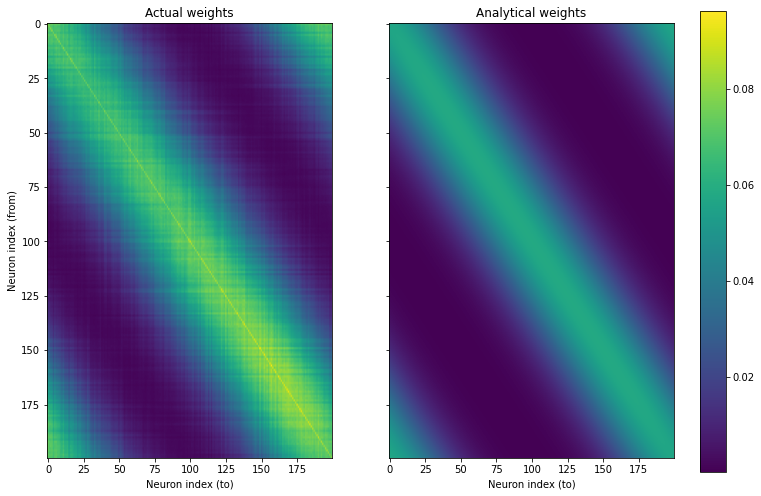

In [40]:
analytical_weights = np.zeros((num_neurons,num_neurons))
for pre in range(num_neurons):
	for post in range(num_neurons):
		x_pre = input_voltage[pre,:period] / dt / 2
		x_post = input_voltage[post,:period] / dt / 2
		x_post_dot = np.diff(x_post) / dt
		x_pre = x_pre[:len(x_post_dot)]
		x_post = x_post[:len(x_post_dot)]
		analytical_weights[pre,post] = (beta_S*x_pre*dt*x_post*dt).sum()/dt + (beta_A*x_pre*dt*x_post_dot*dt).sum()/dt

fig, axs = plt.subplots(1,2, sharey=True)
min_weight = min(analytical_weights.min().item(), recurrent_connection.w.min().item())
max_weight = max(analytical_weights.max().item(), recurrent_connection.w.max().item())

img1 = axs[0].imshow(recurrent_connection.w, vmin=min_weight, vmax=max_weight, aspect='auto')
img2 = axs[1].imshow(analytical_weights, vmin=min_weight, vmax=max_weight, aspect='auto')
axs[0].set_title('Actual weights')
axs[1].set_title('Analytical weights')
axs[0].set_ylabel('Neuron index (from)')
axs[0].set_xlabel('Neuron index (to)')
axs[1].set_xlabel('Neuron index (to)')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])
fig.colorbar(img2, cax=cbar_ax)
plt.show()

Looking at the weight profile - the simulation weight kernel has a larger standard deviation than the predicted weights. This could come from the approximation neglecting the convolution with the kernel (even though it is fairly narrow)

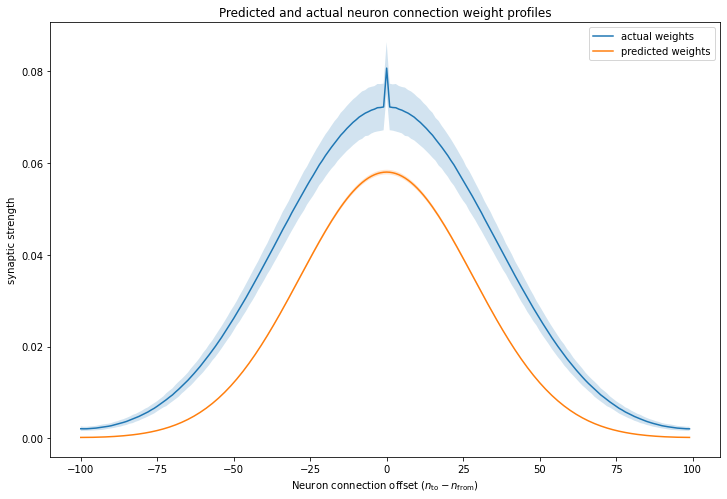

In [41]:
plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(recurrent_connection.w), get_weight_periodic_profile_stdev(recurrent_connection.w), label='actual weights')
plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(torch.Tensor(analytical_weights)), get_weight_periodic_profile_stdev(torch.Tensor(analytical_weights)), label='predicted weights')
plt.legend()
plt.title('Predicted and actual neuron connection weight profiles')
plt.xlabel(r'Neuron connection offset ($n_{\rm{to}} - n_{\rm{from}}$)')
plt.ylabel('synaptic strength')
plt.show()